# This is a demonstration of a basic multimetric experiment in SigOpt

> The goal of this problem is to allow clients to simultaneously maximize two metrics which are in "competition"; that is, no single input yields the maximal output for both metrics.  Consequently, the "solution" to this problem is not a single point, but rather a set of [efficient](https://en.wikipedia.org/wiki/Pareto_efficiency) points where any improvement in one criteria necessitates a decrease in quality of the other.  Studying this set of efficient points, sometimes referred to as the Pareto frontier, provides insight into the possible efficient decisions that can be made.

More discussion is available in our [documentation](https://www.sigopt.com/docs/overview/multimetric) as well as our blog posts [here](http://blog.sigopt.com/post/151388283013/sigopt-in-depth-building-a-better-mousetrap-via) and [here](http://blog.sigopt.com/post/149041563563/sigopt-in-depth-intro-to-multicriteria).  In addition to the term multimetric, much of the literature also uses the term multicriteria or multiobjective.  Furthermore, it should be noted that this is an *alpha* feature in SigOpt, and development continues to be underway.

Below we create the standard SigOpt [connection](https://sigopt.com/docs/overview/python) tool.  If the `SIGOPT_API_TOKEN` is present in the environment variables, it is imported; otherwise, you need to copy and paste your key from the [API tokens page](https://sigopt.com/tokens) in place of `None`.

In [1]:
import os
import numpy
from time import sleep
from matplotlib import pyplot as plt
%matplotlib inline

# Matplotlib stuff for generating plots
efficient_opts = {'linewidth': 0, 'marker': '+', 'color': 'r', 'markersize': 10, 'markeredgewidth': 2}
dominated_opts = {'linewidth': 0, 'marker': '.', 'color': 'k', 'alpha': .4}

from sigopt.interface import Connection

if 'SIGOPT_API_TOKEN' in os.environ:
    SIGOPT_API_TOKEN = os.environ['SIGOPT_API_TOKEN']
else:
    SIGOPT_API_TOKEN = None
    
assert SIGOPT_API_TOKEN is not None
conn = Connection(client_token=SIGOPT_API_TOKEN)

Here, we define the information which defines the [experiment](https://sigopt.com/docs/overview/create):

* `name` - Experiment name, can be whatever you like
* `metrics` - The names of the metrics under consideration; **limited to two** at this point
* `parameters` - The description and range of inputs to the problem
* `type` - Must be `'offline'` for multicriteria problems
* `observation_budget` - The minimum number of observations you are willing to make, required for multicriteria problems

In [2]:
parameters = [
    {
        'bounds': {'max': 10, 'min': 0},
        'name': 'x1',
        'type': 'double',
    },
    {
        'bounds': {'max': 10, 'min': 0},
        'name': 'x2',
        'type': 'double',
    },
]
metrics = [
    {'name': 'f1'},
    {'name': 'f2'},
]

experiment_meta = {
    'name': 'SigOpt Multimetric Demo 2D Quadratic Polynomial (Python)',
    'metrics': metrics,
    'parameters': parameters,
    'type': 'offline',
    'observation_budget': 100,
}

Actually create the experiment.

**Note**: Unlike our typical experiments, multicriteria experiments are immutable. That is, after creation the parameters, metrics and budget cannot be changed.

In [3]:
experiment = conn.experiments().create(**experiment_meta)

Define the function, which has two outputs, which we want to maximize.  Here, both outputs are simply quadratic functions, so as to easily demonstrate the solution.

We also write a function which takes in suggested assignments and returns a list of dictionaries which each contain a metric name (as defined in the meta above) and value for the SigOpt observation creation.

In [4]:
def evaluate_function(assignments):
    x1 = assignments['x1']
    x2 = assignments['x2']
    
    f1_val = -((x1 - 7) ** 2 + (x2 - 8) ** 2)
    f2_val = -((x1 - 1) ** 2 + (x2 - 4) ** 2)
    
    return [{'name': 'f1', 'value': f1_val}, {'name': 'f2', 'value': f2_val}]

Below is the standard [optimization loop](https://sigopt.com/docs/overview/optimization) that always occurs in a SigOpt experiment.  With the `create_observation` function definted above, this looks essentially the same as the single criteria loop.

Note the presence of the `sleep(2)` command.  This is to simulate the actual cost of creating an observation in, e.g., a [machine learning problem](svm_example.ipynb).  It allows SigOpt time to consider information present and prepare for the next observation/suggestion.

In [5]:
while experiment.progress.observation_count < experiment.observation_budget:
    suggestion = conn.experiments(experiment.id).suggestions().create()
    sleep(2)
    values = evaluate_function(suggestion.assignments);
    conn.experiments(experiment.id).observations().create(suggestion=suggestion.id, values=values)
    experiment = conn.experiments(experiment.id).fetch()

## Interpreting results

We need to extract the results of the optimization from the SigOpt experiment.

Recall that metric evaluations are organized in **alphabetical order** when returned from SigOpt, which may differ from the order in which they were originally defined in the experiment.  The loop below recovers the values in the same order in which they were defined initially.

We also produce a large number of random results which show the spread of the feasible region, only possible because the actual function evaluations are cheap (unlike in a real experiment).

In [6]:
pareto_efficient_results = conn.experiments(experiment.id).best_assignments().fetch()
efficient_points = numpy.empty((pareto_efficient_results.count, 2))
efficient_values = numpy.empty((pareto_efficient_results.count, 2))
for k, data in enumerate(pareto_efficient_results.data):
    efficient_points[k, :] = [data.assignments['x1'], data.assignments['x2']]
    dv = {d.name: d.value for d in data.values}
    efficient_values[k, :] = [dv[m['name']] for m in experiment_meta['metrics']]

rand_pts = numpy.random.uniform(
    [p['bounds']['min'] for p in experiment_meta['parameters']],
    [p['bounds']['max'] for p in experiment_meta['parameters']],
    (1000, 2)
)
random_values = numpy.empty((len(rand_pts), 2))
for k, pt in enumerate(rand_pts):
    random_values[k, :] = [v['value'] for v in evaluate_function({'x1': pt[0], 'x2': pt[1]})]

Below is a comparison between randomly chosen points and SigOpt's result.  As can be easily seen, SigOpt does a better job than randomness of identifying efficient behavior.

The graph on the left displays the spread of "solutions" observed during the optimization (as well as a sampling of uniformly randomly sampled inputs).  The black points were randomly sampled, and the red + are the efficient points, where one metric cannot be improved without hurting the other.  These comprise the best_assignments.

The graph on the right displays the parameters which yielded the efficient frontier on the left.  Once the efficient frontier has been surveyed at the end of the experiment, the desired outcomes can be chosen and the parameters for production can be selected.

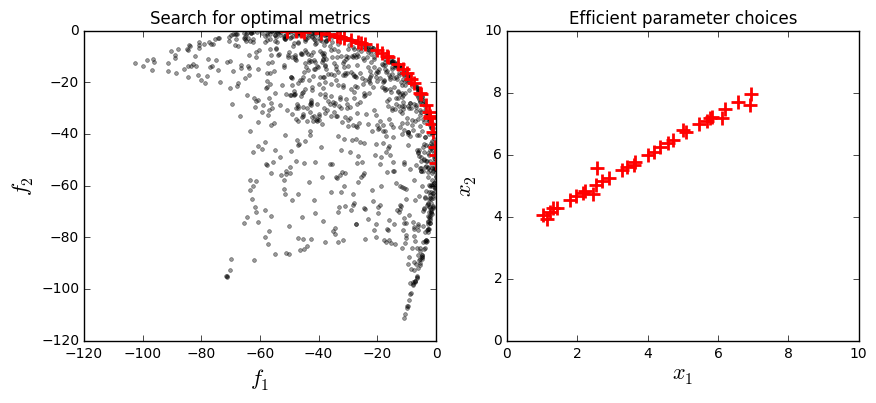

In [7]:
fs = 16
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(random_values[:, 0], random_values[:, 1], **dominated_opts)
ax1.plot(efficient_values[:, 0], efficient_values[:, 1], **efficient_opts)
ax1.set_title('Search for optimal metrics')
ax1.set_xlabel('$f_1$', fontsize=fs)
ax1.set_ylabel('$f_2$', fontsize=fs)

ax2.plot(efficient_points[:, 0], efficient_points[:, 1], **efficient_opts)
ax2.set_title('Efficient parameter choices')
ax2.set_xlim((experiment.parameters[0].bounds.min, experiment.parameters[0].bounds.max))
ax2.set_ylim((experiment.parameters[1].bounds.min, experiment.parameters[1].bounds.max))
ax2.set_xlabel('$x_1$', fontsize=fs)
ax2.set_ylabel('$x_2$', fontsize=fs);